<h1>Hands on Session </h1>
This notebook gives the step by step instructions on how to create ARIMA Model  on Store Sales Dataset from Kaggle
from Kaggle.

## Import the packages required for the excersice

In [56]:
import math
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm
import seaborn as sb
from sklearn.metrics import mean_squared_error
from bokeh.io import output_notebook, show 
from bokeh.plotting import figure
import matplotlib.pyplot as plt
output_notebook()
%load_ext autoreload
%autoreload 1
%matplotlib inline
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize']=(6,4)

Loading BokehJS ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import and Collate Dataset

In [57]:
print("Load the training, test and store data using pandas")
train = pd.read_csv("train.csv")
store = pd.read_csv("store.csv")

Load the training, test and store data using pandas


In [63]:
train["Date"] = pd.to_datetime(train["Date"]).dt.date
train = train.sort_values(by='Date')
###### 
y=train[train.Store==6].set_index('Date')[['Sales']].asfreq('D')
X=train[train.Store==6].set_index('Date').asfreq('D')
y.shape[0]==942 

True

### Visualize the Data

In [64]:
train.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
905,906,5,2015-07-31,15131,1482,1,1,0,1
904,905,5,2015-07-31,8157,1123,1,1,0,1
410,411,5,2015-07-31,12977,882,1,1,0,1
412,413,5,2015-07-31,10228,1110,1,1,0,0
0,1,5,2015-07-31,5263,555,1,1,0,1


In [54]:
train[train['Store']==1].head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1016095,1,2,2013-01-01,0,0,0,0,a,1
1014980,1,3,2013-01-02,5530,668,1,0,0,1
1013865,1,4,2013-01-03,4327,578,1,0,0,1
1012750,1,5,2013-01-04,4486,619,1,0,0,1
1011635,1,6,2013-01-05,4997,635,1,0,0,1


In [29]:
ts=pd.DataFrame(y)

##  Exploratory Data Analysis

### Visualize the time Series Data

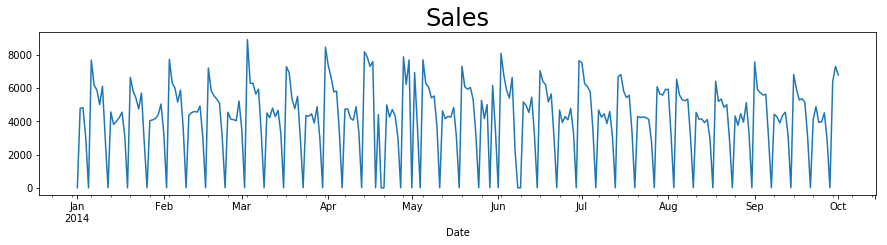

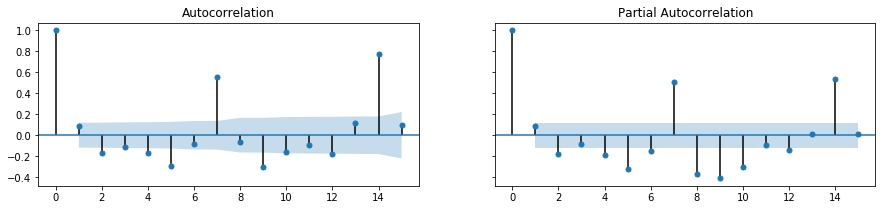

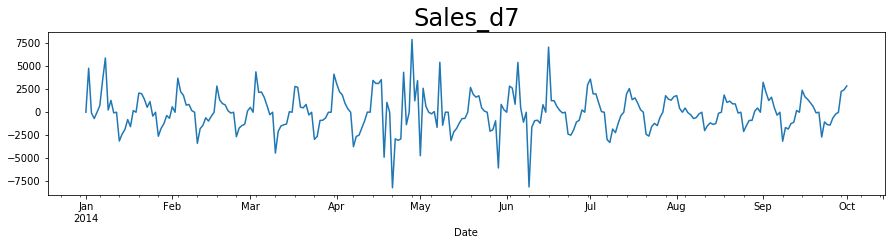

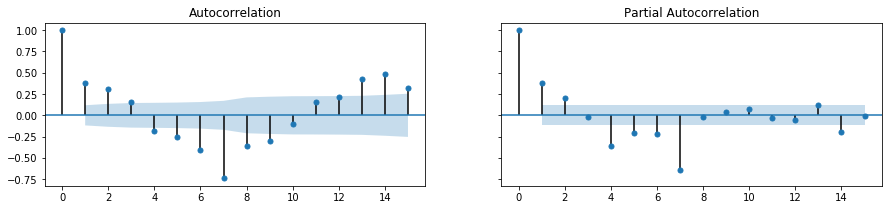

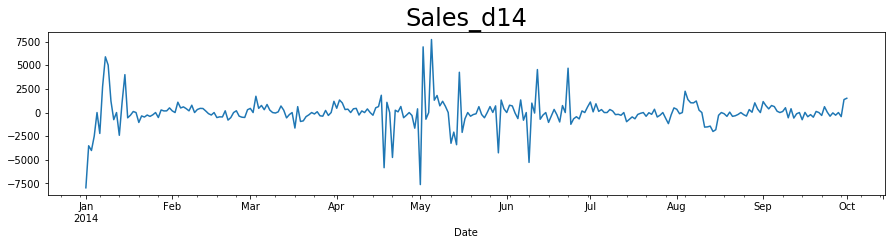

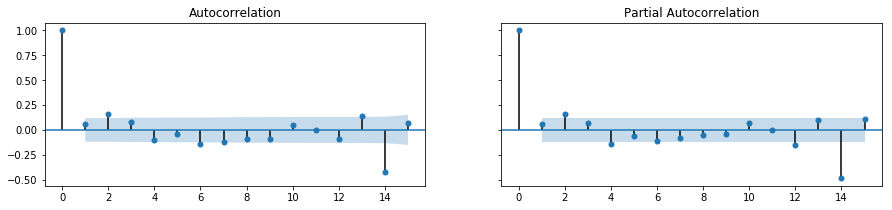

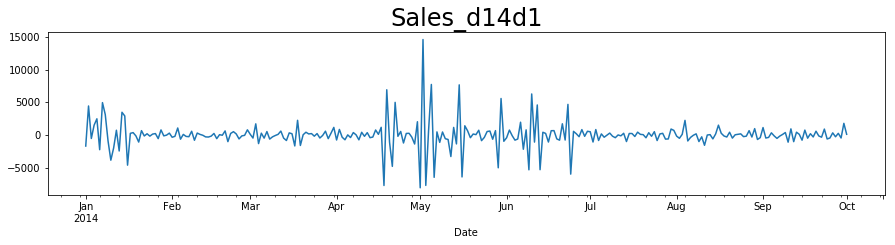

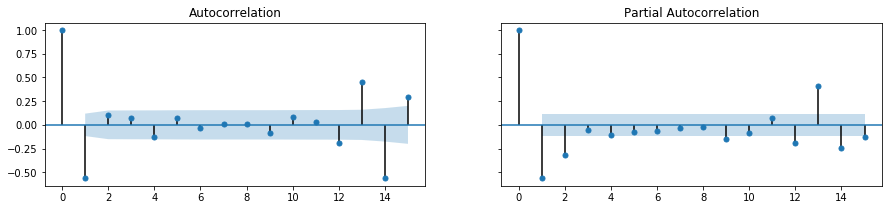

In [65]:
# ts['ln_Sales'] = np.log(ts.Sales+100)
X_train['Sales_d7'] = ts.Sales.diff(7)
X_train['Sales_d14'] = ts.Sales.diff(14)
X_train['Sales_d14d1'] = ts.Sales.diff(14).diff(1)
# Graph data
for x in [X_train.Sales,X_train.Sales_d7,X_train.Sales_d14,X_train.Sales_d14d1]:
    fig, axes = plt.subplots(1, 1, figsize=(15,3))
    x=x['2014-01-01':'2014-10-01']
    ax=x.plot(ax=axes)
    ax.set_title(x.name)
    ax.title.set_fontsize(24)
    
    fig, axes = plt.subplots(1, 2, figsize=(15,3),sharex=True,sharey=True)
    sm.graphics.tsa.plot_acf(x, lags=15,ax=axes[0]);
    sm.graphics.tsa.plot_pacf(x, lags=15, ax=axes[1]);

## Feature Cleaning

## Feature Engineering

In [66]:
_X=X_exog[['Open','Promo','SchoolHoliday']]
_X['StateHoliday']=X_exog.StateHoliday.astype(str).replace(['a', 'b', 'c'],'0').astype(np.float)
_X['Month']=X_exog.index.month
_X['WeekDay']=X_exog.index.weekday
_X['time']=(X_exog.index-X_exog.index.min()).days
_X['const']=1
_X
_Y=Y_exog[['Open','Promo','SchoolHoliday']]
_Y['StateHoliday']=Y_exog.StateHoliday.astype(str).replace(['a', 'b', 'c'],'0').astype(np.float)
_Y['Month']=Y_exog.index.month
_Y['WeekDay']=Y_exog.index.weekday
_Y['time']=(Y_exog.index-Y_exog.index.min()).days
_Y['const']=1

## Model Development

### Divide data into Train Test Split

In [67]:
X_train = ts[ts.index < '2015-04-01']
X_exog = X[X.index < '2015-04-01']
X_test = ts[ts.index >=  '2015-04-01']
Y_exog = X[X.index >= '2015-04-01']
len(X_test)

122

### Model Development

In [68]:
%%time
# (3,0,0,2,1,1,14)
# (3,0,0,3,2,1,14)
s=[7,14]
Q=[0,1]
D=[0,1]
P=[1,2]
q=[0,1]
d=[0,1]
p=[2,3]

import itertools
orders=list(itertools.product(p,d,q,P,D,Q,s))
counter=len(orders)
res={}
for (p,d,q,P,D,Q,s) in orders:
    arma = SARIMAX(X_train.Sales,exog=_X, trend=None, order=(p,d,q),seasonal_order=(P,D,Q,s))
    try:
        arma = arma.fit(method='lbfgs',maxiter=50)
        res[(p,d,q,P,D,Q,s)]=(arma.aic,arma.bic)
        counter-=1
        print('finish {}, {} remains'.format((p,d,q,P,D,Q,s),counter))
    except:
        print('order {} fail'.format((p,d,q,P,D,Q,s)))

finish (2, 0, 0, 1, 0, 0, 7), 127 remains
finish (2, 0, 0, 1, 0, 0, 14), 126 remains
finish (2, 0, 0, 1, 0, 1, 7), 125 remains
finish (2, 0, 0, 1, 0, 1, 14), 124 remains
finish (2, 0, 0, 1, 1, 0, 7), 123 remains
finish (2, 0, 0, 1, 1, 0, 14), 122 remains
finish (2, 0, 0, 1, 1, 1, 7), 121 remains
finish (2, 0, 0, 1, 1, 1, 14), 120 remains
finish (2, 0, 0, 2, 0, 0, 7), 119 remains
finish (2, 0, 0, 2, 0, 0, 14), 118 remains
finish (2, 0, 0, 2, 0, 1, 7), 117 remains
finish (2, 0, 0, 2, 0, 1, 14), 116 remains
finish (2, 0, 0, 2, 1, 0, 7), 115 remains
finish (2, 0, 0, 2, 1, 0, 14), 114 remains
finish (2, 0, 0, 2, 1, 1, 7), 113 remains
finish (2, 0, 0, 2, 1, 1, 14), 112 remains
order (2, 0, 1, 1, 0, 0, 7) fail
order (2, 0, 1, 1, 0, 0, 14) fail
order (2, 0, 1, 1, 0, 1, 7) fail
order (2, 0, 1, 1, 0, 1, 14) fail
finish (2, 0, 1, 1, 1, 0, 7), 111 remains
finish (2, 0, 1, 1, 1, 0, 14), 110 remains
finish (2, 0, 1, 1, 1, 1, 7), 109 remains
finish (2, 0, 1, 1, 1, 1, 14), 108 remains
order (2, 0, 1, 

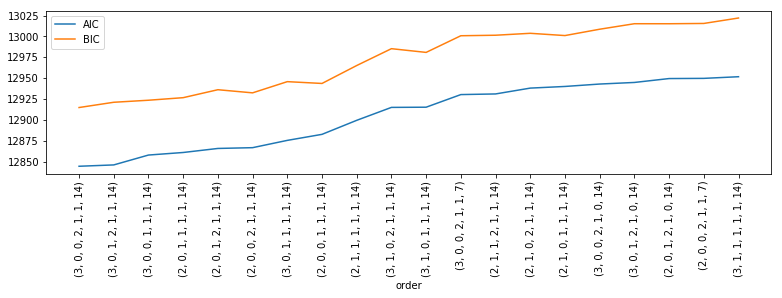

In [69]:
df=pd.DataFrame([ (k, v[0],v[1]) for k,v in res.items()],columns=['order','AIC','BIC'])
df=df.sort_values('AIC').set_index('order')
n=20
ax=df[:n].plot(rot=90)
ax.set_xticks(range(n))
ax.set_xticklabels(df[:n].index.values);
ax.figure.set_size_inches(13,3)

### Call Seasonal ARIMA 

In [70]:
SARIMAX = sm.tsa.statespace.SARIMAX

In [74]:
arma = SARIMAX(X_train.Sales, exog=_X, trend=None, order=(3,0,0),seasonal_order=(2,1,1,14))
%time arma = arma.fit()
print(arma.summary())

CPU times: user 2min 25s, sys: 350 ms, total: 2min 25s
Wall time: 24.4 s
                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  820
Model:             SARIMAX(3, 0, 0)x(2, 1, 1, 14)   Log Likelihood               -6407.203
Date:                            Tue, 22 Jan 2019   AIC                          12844.406
Time:                                    18:12:03   BIC                          12914.787
Sample:                                01-01-2013   HQIC                         12871.433
                                     - 03-31-2015                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Open           5473.3596     92.923

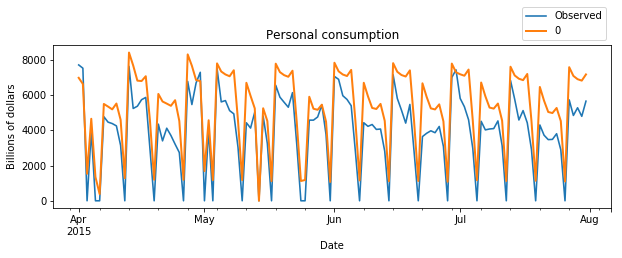

In [75]:
# Dynamic predictions
predict_dy = pd.DataFrame(arma.forecast(len(X_test),exog=_Y))
predict_dy[0] = np.where((predict_dy[0] <= 0) ,0, predict_dy[0])

# Graph
fig, ax = plt.subplots(figsize=(10,3))
ax.set(title='Personal consumption', xlabel='Date', ylabel='Billions of dollars')
t_start='2015-04-01'
pred_start = '2015-04-01'
t_end='2015-07-31'
# Plot data points
ts.Sales.ix[t_start:t_end].plot(ax=ax, style='-',linewidth=1.6, label='Observed')
# Plot predictions
predict_dy[t_start:t_end].plot(ax=ax,style='-',linewidth=2, label='forecast')
legend = ax.legend(loc='lower right',bbox_to_anchor=(1,1))

In [76]:
measure = math.pow(mean_squared_error(X_test.Sales.values,predict_dy.values), 0.5)
print("RMSE:", measure)

RMSE: 1508.161126485573
